In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as plt
import missingno as msno
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import *

## 1. 데이터 불러온후, One-hot encoding

In [2]:
# 데이터 불러오기
df = pd.read_csv('/Users/stone/programing/jupyter_notebook/Fake_Bill/fake_bills.csv', sep = ';')

df.head()


,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54


In [3]:
# one-hot encoding , true : 1 ; False : 0

df['is_genuine'] = df['is_genuine'].replace({True: 1, False: 0})
df.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,1,171.81,104.86,104.95,4.52,2.89,112.83
1,1,171.46,103.36,103.66,3.77,2.99,113.09
2,1,172.69,104.48,103.50,4.40,2.94,113.16
3,1,171.36,103.91,103.94,3.62,3.01,113.51
4,1,171.73,104.28,103.46,4.04,3.48,112.54


In [4]:
# 혹시 전부다 1만 되지는 않았는가?
df['is_genuine'].value_counts()

1    1000
0     500
Name: is_genuine, dtype: int64

## 2.결측치 확인, knn으로 채우기

In [5]:
# 우선 pandas로 결측치 확인
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   int64  
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1463 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 82.2 KB


<AxesSubplot:>

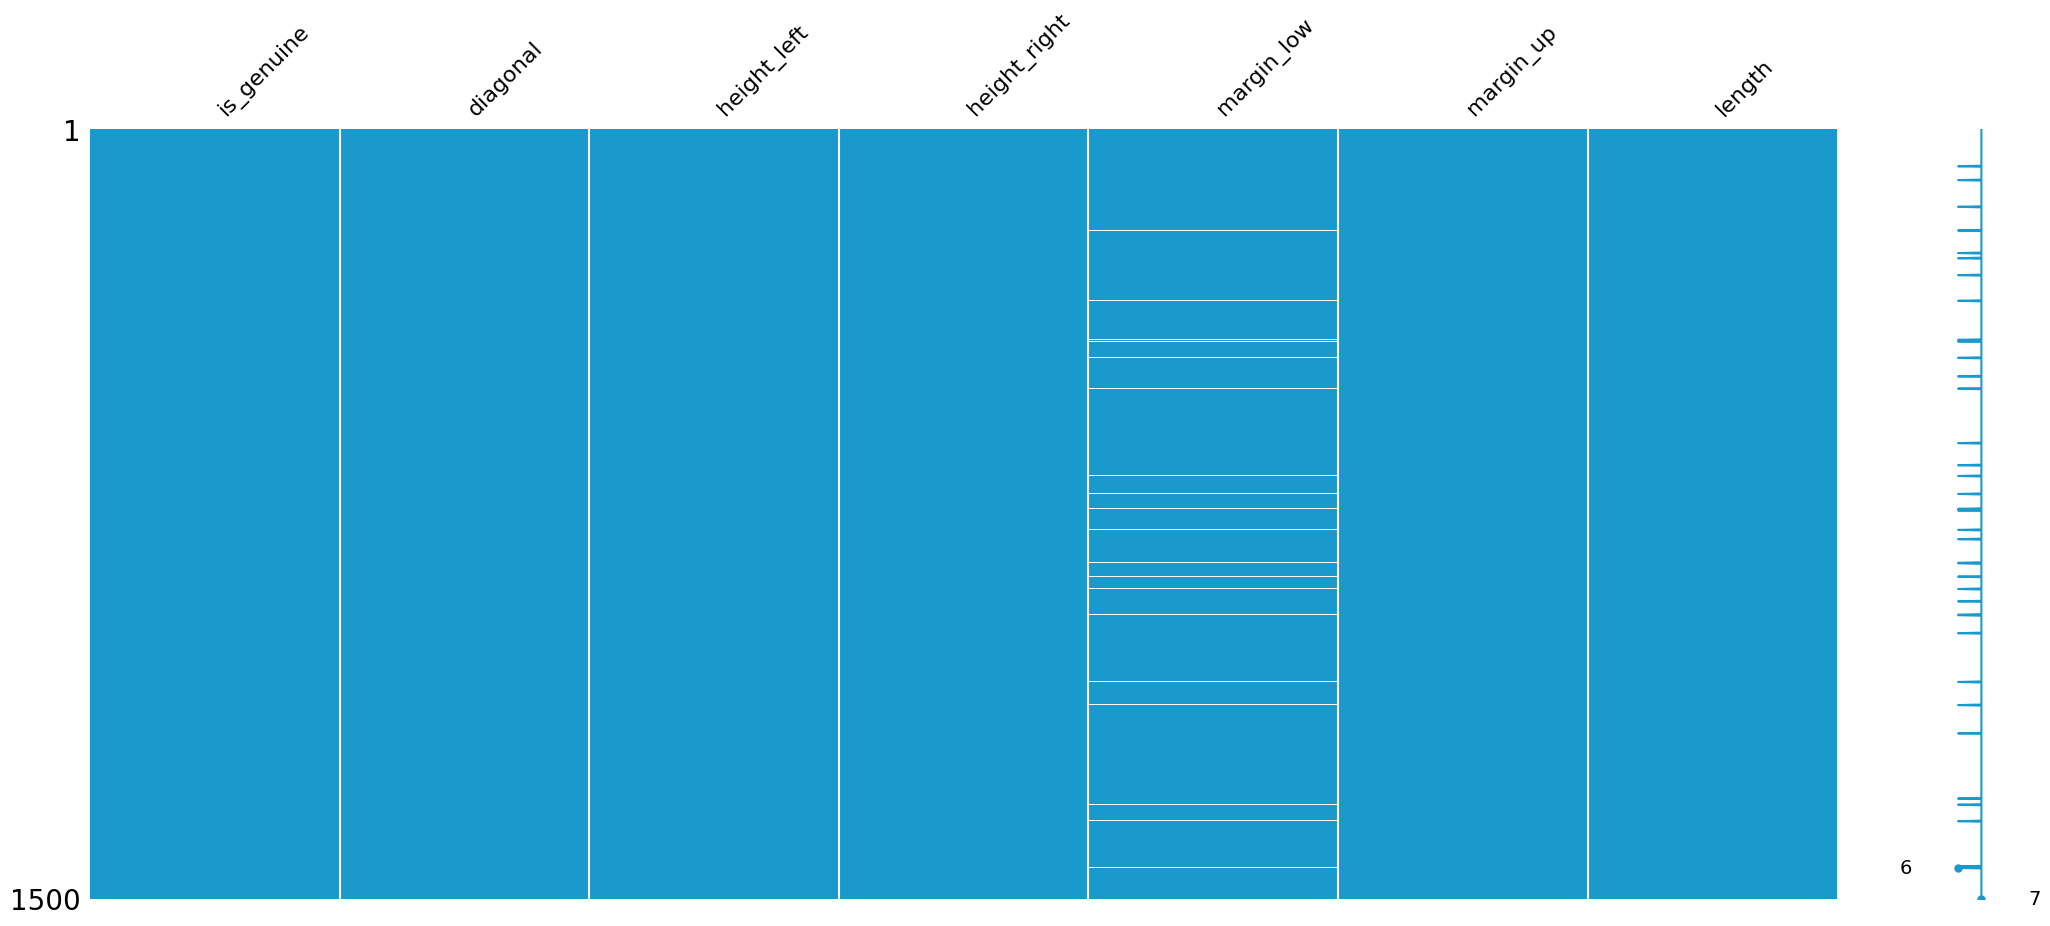

In [6]:
msno.matrix(df=df.iloc[:, :], color=(0.1, 0.6, 0.8))

<AxesSubplot:>

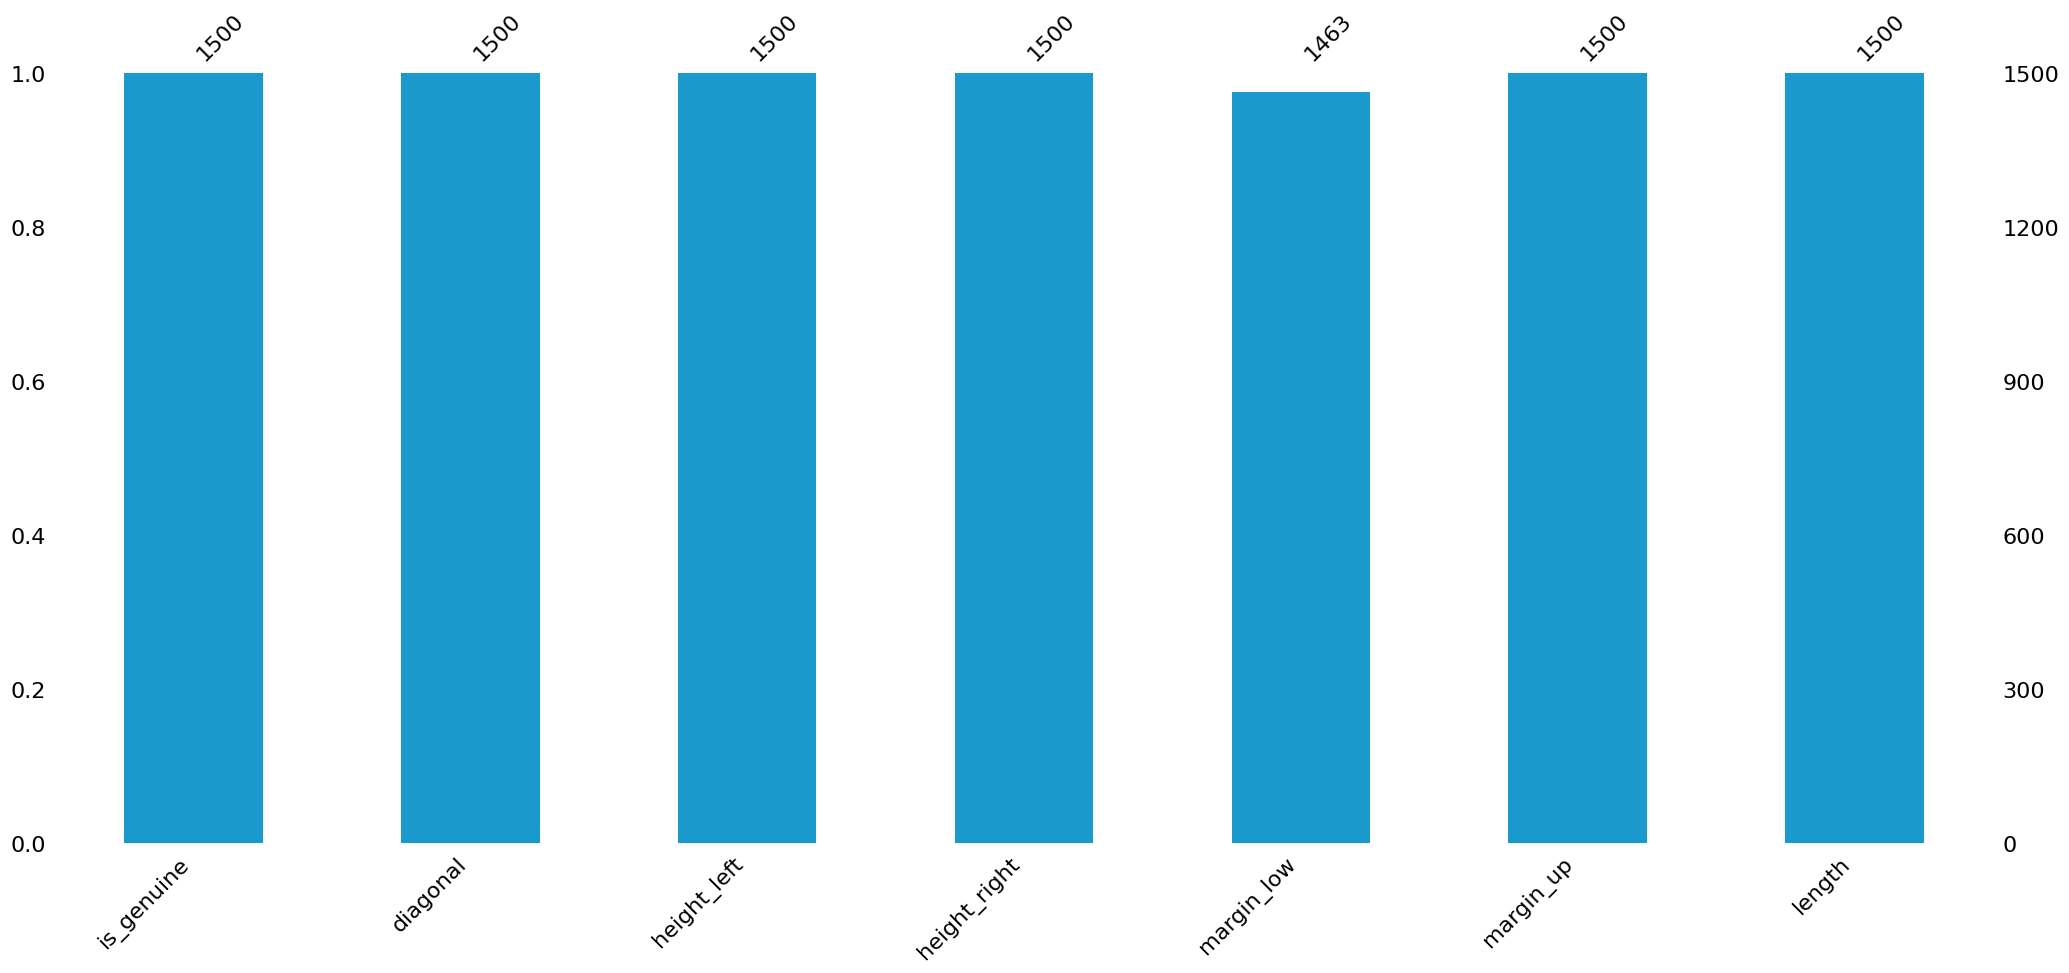

In [7]:
msno.bar(df=df, color=(0.1, 0.6, 0.8))

In [8]:
# 결측치 knn으로 넣기

imputer = KNNImputer(n_neighbors = 3)
df_filled = imputer.fit_transform(df)

df_filled = pd.DataFrame(df_filled,columns = df.columns)
# 다 채워짐
df_filled.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   float64
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1500 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: float64(7)
memory usage: 82.2 KB


In [9]:
df_filled.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,1.0,171.81,104.86,104.95,4.52,2.89,112.83
1,1.0,171.46,103.36,103.66,3.77,2.99,113.09
2,1.0,172.69,104.48,103.50,4.40,2.94,113.16
3,1.0,171.36,103.91,103.94,3.62,3.01,113.51
4,1.0,171.73,104.28,103.46,4.04,3.48,112.54


## 3. pairplot, np.corrcoef

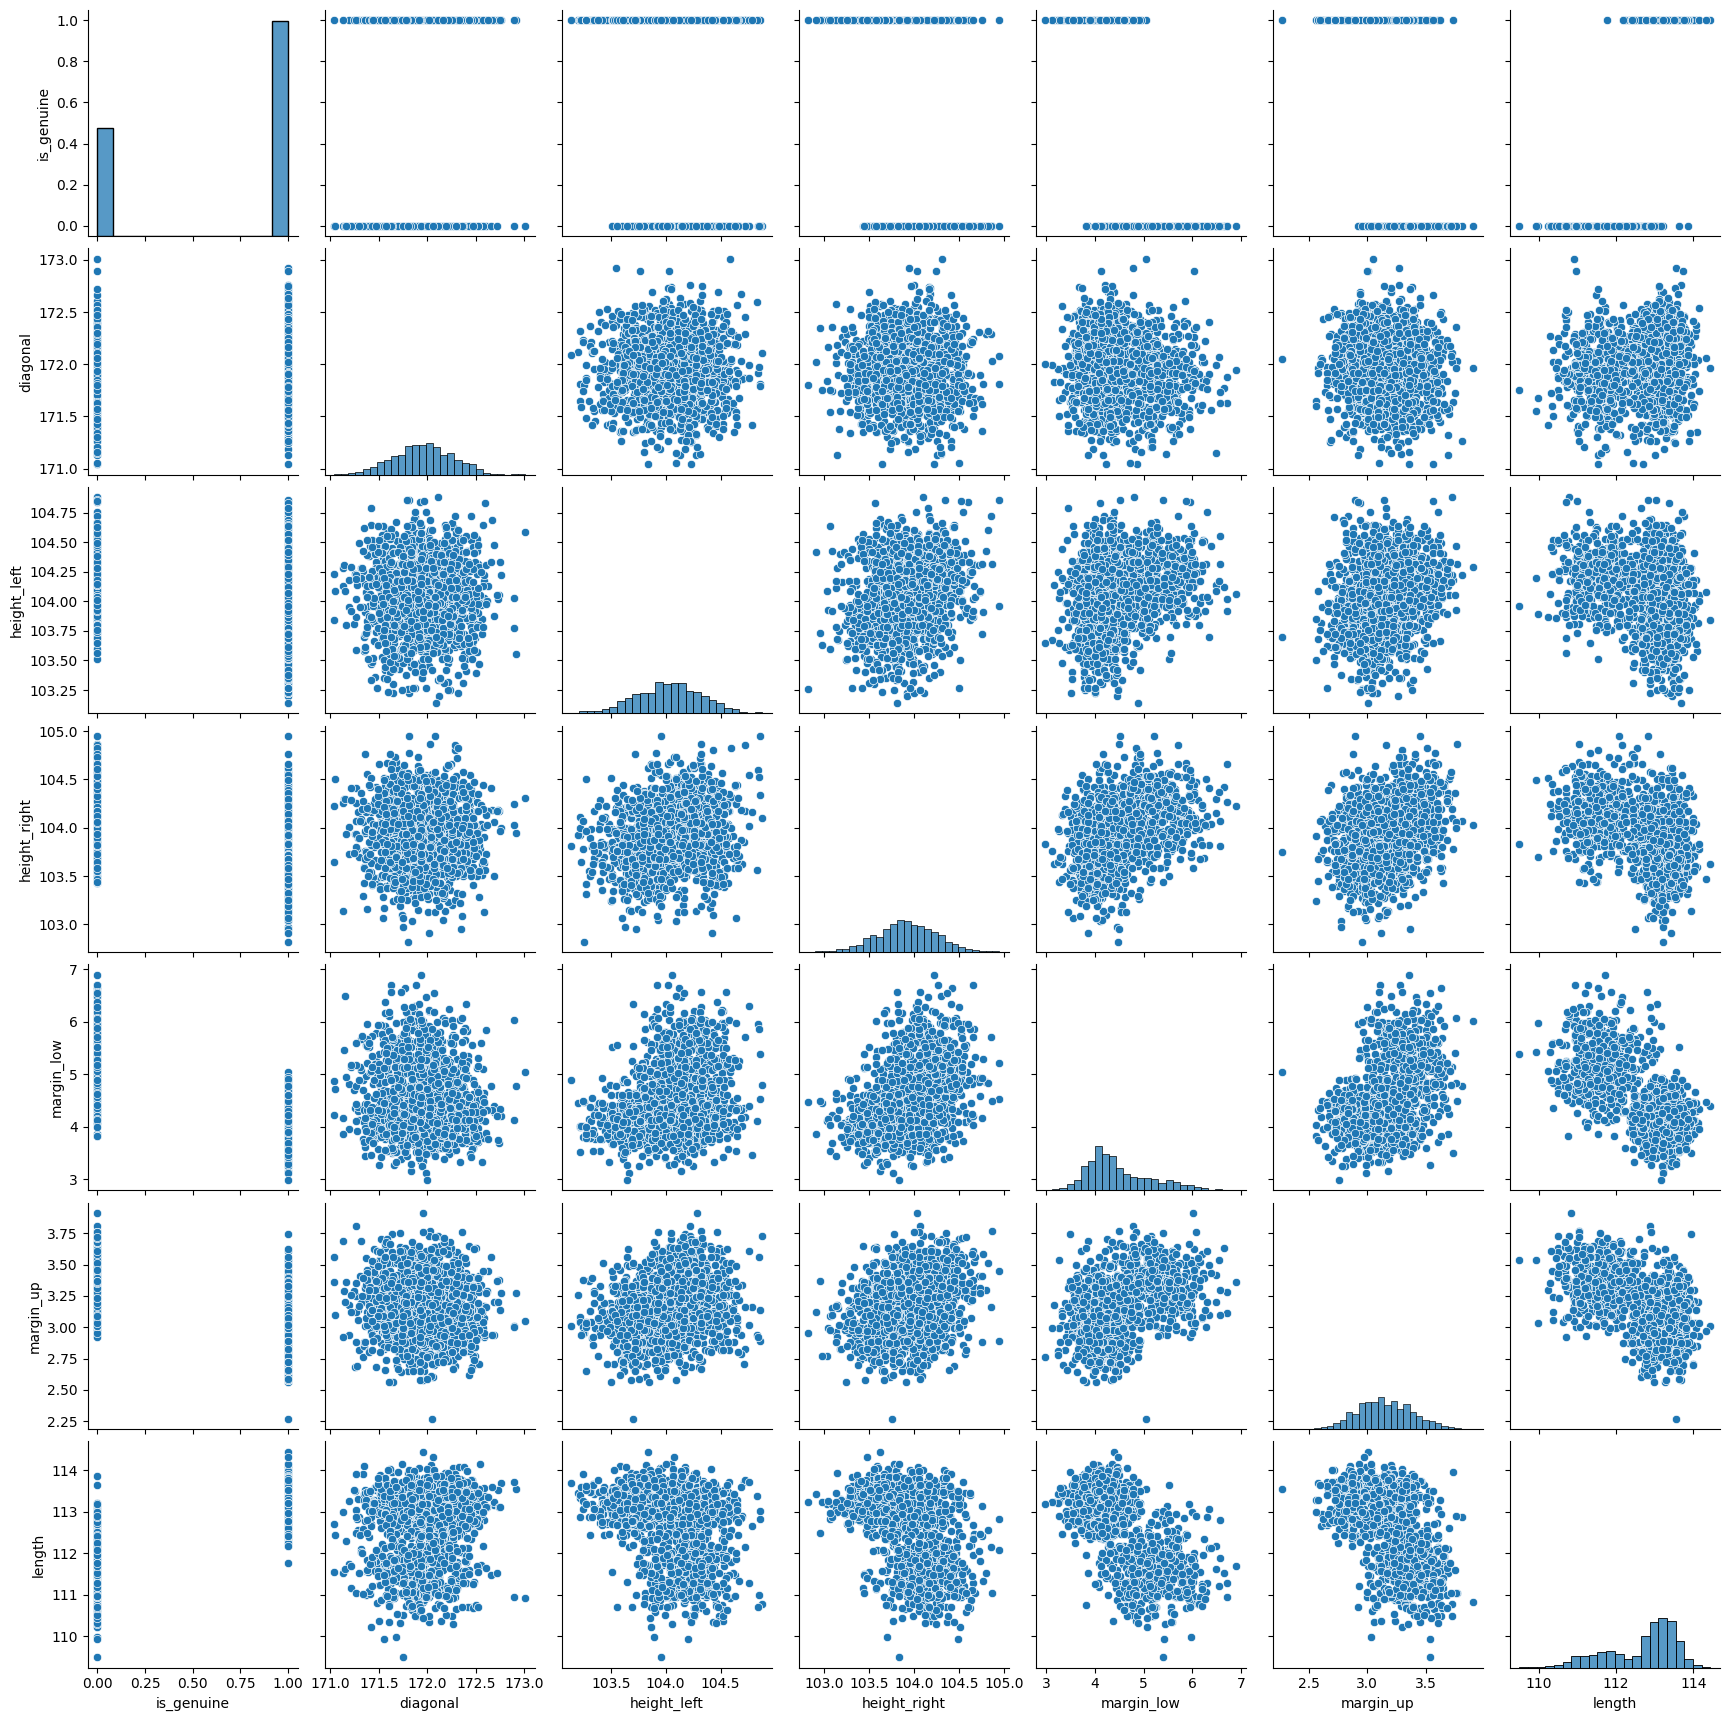

In [10]:
# pairplot
sns.pairplot(df_filled)


<AxesSubplot:>

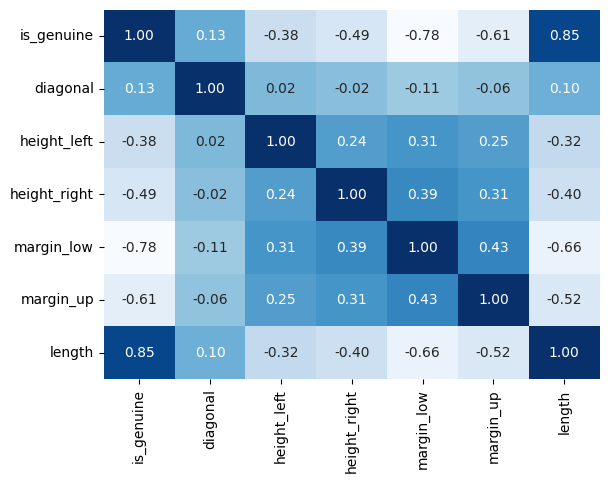

In [11]:
corr = df_filled.corr()
sns.heatmap(corr, annot=True, fmt='.2f', cbar=None, cmap='Blues')

## 4. train,test set 구분

In [12]:
# df_filled는 1,0으로 모두 기록된 자료 -> 이것으로 먼저 자른후, one-hot 답을 붙이자.

# split, 'is_genuine'을 기준으로 자름
df_train,df_test = train_test_split(df_filled,test_size = 0.3,stratify = df_filled['is_genuine'],random_state = 2)

In [13]:
print(df_train['is_genuine'].value_counts())
print(df_test['is_genuine'].value_counts())


1.0    700
0.0    350
Name: is_genuine, dtype: int64
1.0    300
0.0    150
Name: is_genuine, dtype: int64


In [14]:
df_train.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
115,1.0,171.88,103.61,103.46,3.52,2.99,112.94
46,1.0,171.47,103.74,104.42,4.19,2.92,113.53
782,1.0,172.25,104.02,104.16,3.87,3.16,113.77
825,1.0,171.94,104.03,103.49,4.16,2.87,113.05
265,1.0,172.15,104.02,103.94,3.96,2.87,112.38


## 5. standardization, train_x을 기준으로

In [15]:
train_x = df_train.iloc[:,1:]
train_y = df_train.iloc[:,:1]
test_x = df_test.iloc[:,1:]
test_y = df_test.iloc[:,:1]

In [16]:
train_y.head()

,is_genuine
115,1.0
46,1.0
782,1.0
825,1.0
265,1.0


In [17]:
scaler = StandardScaler()   

scaler = scaler.fit(train_x)
train_x = scaler.transform(train_x)
test_x = scaler.transform(test_x)

In [18]:
train_x = pd.DataFrame(train_x)
test_x = pd.DataFrame(test_x)

In [19]:
train_x.head()

,0,1,2,3,4,5
0,-0.250097,-1.400025,-1.435044,-1.449609,-0.677046,0.308556
1,-1.582936,-0.968923,1.515481,-0.432606,-0.976335,0.983642
2,0.952709,-0.040394,0.716381,-0.918339,0.049800,1.258253
3,-0.055047,-0.007232,-1.342841,-0.478143,-1.190113,0.434419
4,0.627626,-0.040394,0.040218,-0.781726,-1.190113,-0.332203


## 6. Grid_Search

In [20]:
def print_metrics(model, X_train):
    scores = cross_val_score(model, X_train, train_y, cv=10)
    print('*** Cross val score *** \n   {}'.format(scores))
    print('\n*** Mean Accuracy *** \n   {:.7f}'.format(scores.mean()))
    # print('\n*** Confusion Matrix *** \n', confusion_matrix(y_train, model.predict(X_train)))

In [21]:
knn_s = KNeighborsClassifier()
knn_s.fit(train_x, train_y)
print_metrics(knn_s, train_x)

# 결과:
'''
*** Cross val score *** 
   [0.98095238 1.         0.99047619 0.99047619 1.         0.99047619
 1.         0.99047619 0.99047619 1.        ]

*** Mean Accuracy *** 
   0.9933333
'''



*** Cross val score *** 
   [0.98095238 1.         0.99047619 0.99047619 1.         0.99047619
 1.         0.99047619 0.99047619 1.        ]

*** Mean Accuracy *** 
   0.9933333


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neighb

'\n*** Cross val score *** \n   [0.98095238 1.         0.99047619 0.99047619 1.         0.99047619\n 1.         0.99047619 0.99047619 1.        ]\n\n*** Mean Accuracy *** \n   0.9933333\n'

In [22]:
grid_params = {
    'n_neighbors' : list(range(1,20)),
    'weights' : ["uniform", "distance"],
    'metric' : ['euclidean', 'manhattan', 'minkowski']
}




In [23]:
gs_s = GridSearchCV(knn_s, grid_params, cv=10)
gs_s.fit(train_x, train_y)
print("Best Parameters : ", gs_s.best_params_)
print("Best Score : ", gs_s.best_score_)
print("Best Test Score : ", gs_s.score(train_x, train_y))

# 결과:
"""
Best Parameters :  {'metric': 'euclidean', 'n_neighbors': 4, 'weights': 'uniform'}
Best Score :  0.9933333333333334
Best Test Score :  0.9942857142857143

"""


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neighb

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neighb

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neighb

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neighb

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neighb

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neighb

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neighb

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neighb

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neighb

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neighb

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neighb

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neighb

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neighb

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neighb

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neighb

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neighb

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neighb

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neighb

Best Parameters :  {'metric': 'euclidean', 'n_neighbors': 4, 'weights': 'uniform'}
Best Score :  0.9933333333333334
Best Test Score :  0.9942857142857143


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neighb

"\nBest Parameters :  {'metric': 'euclidean', 'n_neighbors': 4, 'weights': 'uniform'}\nBest Score :  0.9933333333333334\nBest Test Score :  0.9942857142857143\n\n"

## 7. gridsearch에서 나온 결과를 바탕으로 hyperparameter 설정, test

In [24]:

knn_m = KNeighborsClassifier(metric = 'euclidean', n_neighbors = 4, weights = 'uniform')
knn_m.fit(train_x, train_y)


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


KNeighborsClassifier(metric='euclidean', n_neighbors=4)

In [25]:
def print_test_metrics(model, X_test):
    print('*** Test Accuracy *** \n   {}'.format(model.score(X_test, test_y)))
    print('\n*** Confusion Matrix *** \n', confusion_matrix(test_y, model.predict(X_test)))
    

In [26]:
print_test_metrics(knn_m, test_x)

*** Test Accuracy *** 
   0.9822222222222222

*** Confusion Matrix *** 
 [[146   4]
 [  4 296]]
